In [24]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch


In [25]:
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [89]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import PConvUNet2D
from src.data import TempoInpaintDataset, Normalizer, load_classification_pickle
from src.losses import calculate_metrics, warmup_loss
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple
# save_classification_pickle(complete, partial, blank, output_file="file_classification_nop.pkl")
complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'

z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)

normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/hpc/home/srs108/TEMPO/cus/cb_2018_us_state_500k.shp"

pandora_df = pd.read_csv("/hpc/home/srs108/TEMPO/pandora_filtered_data.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")

# train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files)
# val_ds = TempoInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files)
# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

# train_ds.sample_vis(train=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)
# ===================================== DATASET ===========================================
# class TempoInpaintDataset(Dataset):
#     F32_MIN = np.float32(-3.4028235e+38).item()

#     def __init__(self,
#                  tif_dir,
#                  normalizer,
#                  subset='complete',
#                  complete_thr=0.01,
#                  blank_thr=0.99,
#                  use_real_gaps_only=True,
#                  use_dataset_mask=True,
#                  treat_zeros_as_missing=False,
#                  valid_range=None,
#                  synth_mask_cfg=None,
#                  file_list=None,
#                  # ---------- Pandora ----------
#                  pandora_csv=None,            # path or DataFrame with columns: datetime, NO2, row, col, (optional: lat, lon, station)
#                  time_tolerance="30min",      # +/- window to match Pandora to raster timestamp
#                  pandora_as_input=True,       # append pandora channels to "inp"
#                  ):
#         assert subset in ('complete', 'partial')
#         self.tif_dir = tif_dir
#         self.normalizer = normalizer
#         self.subset = subset
#         self.use_real_gaps_only = bool(use_real_gaps_only)
#         self.complete_thr = float(complete_thr)
#         self.blank_thr = float(blank_thr)
#         self.use_dataset_mask = bool(use_dataset_mask)
#         self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
#         self.valid_range = valid_range
#         self.synth_mask_cfg = synth_mask_cfg or dict(n_rects=5, min_h=16, max_h=None,
#                                                      min_w=16, max_w=None, p_full_strip=0.1)
#         self.pandora_as_input = bool(pandora_as_input)

#         # --------- load files ----------
#         self.files = list(file_list)

#         # --------- Pandora table ----------
#         self.pandora_df = None
#         self.time_tolerance = pd.Timedelta(time_tolerance)
#         if pandora_csv is not None:
#             if isinstance(pandora_csv, pd.DataFrame):
#                 df = pandora_csv.copy()
#             else:
#                 df = pd.read_csv(pandora_csv)

#             req = {"datetime","NO2"}
#             df["datetime"] = pd.to_datetime(df["datetime"])
#             df = df.sort_values("datetime").reset_index(drop=True)
#             self.pandora_df = df
#     def preview_with_pandora(self, idx=None, shp_path=None,seed=42,
#         save=True, outfile=None):
#         """
#         Left  : TEMPO image in RAW units (missing -> white) + Pandora stations (nearest per station).
#         Right : Real gap mask (1 = hole) + (optionally) Pandora stations.
#         Pandora station names go into a legend with stable colors.
#         """
#         rng = np.random.default_rng(seed)
#         if idx is None:
#             idx = int(rng.integers(low=0, high=len(self.files)))
#         path = self.files[idx]
#         date = path.split('/')[-1].split('.')[0]
#         date = datetime.strptime(date, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

#         # ----- Load image & masks -----
#         arr_valid, known_mask = self._read_band_masked(path)
#         hole_mask = (1.0 - known_mask.astype(np.float32))  # 1=hole

#         finite_vals = arr_valid[np.isfinite(arr_valid)]
#         if finite_vals.size:
#             vmin, vmax = np.percentile(finite_vals, [2, 98])
#             if not np.isfinite(vmin) or not np.isfinite(vmax) or (vmin == vmax):
#                 vmin, vmax = finite_vals.min(), finite_vals.max()
#         else:
#             vmin, vmax = 0.0, 1.0

#         disp_raw = np.ma.masked_invalid(arr_valid)
#         cmap_raw = plt.cm.viridis.copy()
#         cmap_raw.set_bad(color="white")

#         # ----- Timestamp & georef -----
#         with rasterio.open(path) as src:
#             tr  = src.transform
#             crs = src.crs
#             H, W = src.height, src.width
#         ts = self._parse_time_from_fname(os.path.basename(path))
#         xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

#         segments = _load_shapefile_segments_pyshp(shp_path, crs)

#         # ----- Figure -----
#         fig, axes = plt.subplots(1, 2, figsize=(13, 10))
#         im0 = rio_show(disp_raw, transform=tr, ax=axes[0],
#                        cmap=cmap_raw, vmin=vmin, vmax=vmax)

#         axes[0].set_xlim(xmin, xmax);axes[0].set_ylim(ymin, ymax)
#         axes[0].set_aspect('equal', adjustable='box')
#         axes[0].margins(0); axes[0].autoscale(False)
#         axes[0].set_title(f"TEMPO and Pandora\n{date}")
#         axes[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))

#         cbar0 = fig.colorbar(im0.get_images()[0], ax=axes[0], fraction=0.046, pad=0.04)
#         cbar0.set_label("NO₂ (molec$\cdot$cm${^2}$)")

#         # ---------- Right: real gap mask ----------
#         im1 = rio_show(hole_mask, transform=tr, ax=axes[1],
#                        cmap="gray", vmin=0, vmax=1)
#         axes[1].set_title("Real gap mask (0=NA)")
#         axes[1].set_xlim(xmin, xmax); axes[1].set_ylim(ymin, ymax)
#         axes[1].set_aspect('equal', adjustable='box')
#         axes[1].add_collection(LineCollection(segments,colors='red',linewidths=0.5, zorder=3))

#         # ---------- Pandora stations ----------
#         if (getattr(self, "pandora_df", None) is not None) and (ts is not pd.NaT):
#             dfw = self.pandora_df[
#                 (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
#                 (self.pandora_df["datetime"] <= ts + self.time_tolerance)
#             ].copy()
#             if not dfw.empty:
#                 if "station" in dfw.columns:
#                     dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
#                     dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

#                 stations_all = self.pandora_df["station"].unique()
#                 color_map = dict(zip(stations_all,
#                                      cm.tab20c(np.linspace(0, 1, len(stations_all)))))

#                 lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
#                 lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
#                 ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats>=-90) & (lats<=90)
#                 dfw = dfw.loc[ok_ll].copy()
#                 rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
#                 labels = dfw["station"].astype(str).to_numpy()
  
#                 rr_i = rr.astype(int); cc_i = cc.astype(int)
#                 ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
#                 rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

#             if rr_i.size:
#                 xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)
#                 legend_handles = []

#                 for x, y, lab in zip(xs, ys, labels):
#                     c = color_map.get(lab, "red")

#                     # --- Plot with white halo + black edge ---
#                     # First draw a slightly larger white halo underneath
#                     axes[0].scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
#                     axes[1].scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)

#                     # Then draw the actual colored marker with black edge
#                     sc0 = axes[0].scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)
#                     sc1 = axes[1].scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)

#                     # Optional extra stroke effect to make even crisper on busy backgrounds
#                     for sc in (sc0, sc1):
#                         sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'),pe.Normal()])

#                     # --- Legend proxy ---
#                     proxy = Line2D(
#                         [0], [0], marker='D', color='none',
#                         markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
#                         markersize=9, label=lab
#                     )
#                     legend_handles.append(proxy)

#                 # --- Build the legend ---
#                 axes[0].legend(
#                     handles=legend_handles,
#                     bbox_to_anchor=(-0.85, 1),  # push outside left edge
#                     loc="upper left",
#                     borderaxespad=0.,
#                     frameon=True,
#                     fontsize=13,
#                     markerscale=1.2  # enlarges legend symbols
#                 )

#         plt.tight_layout()
#         if save:
#             base = os.path.splitext(os.path.basename(path))[0]
#             out = outfile if outfile else f"preview_pandora_{base}.png"
#             fig.savefig(out, dpi=300, bbox_inches="tight", facecolor="white")
# #             print("Saved:", out)
#         plt.show()
#     # ---------- core I/O & masking ----------
#     def _read_band_masked(self, path):
#         with rasterio.open(path) as src:
#             gdal_known = None
#             if self.use_dataset_mask:
#                 try:
#                     m = src.read_masks(1)  # 0=missing, 255=valid
#                     if m is not None and m.size:
#                         gdal_known = (m > 0)
#                 except Exception:
#                     gdal_known = None

#             arr = src.read(1, out_dtype='float64')
#             nodatas = []
#             if getattr(src, "nodata", None) is not None:
#                 nodatas.append(src.nodata)
#             if getattr(src, "nodatavals", None):
#                 nodatas += [v for v in src.nodatavals if v is not None]

#         known = gdal_known if gdal_known is not None else np.isfinite(arr)
#         for nv in nodatas:  # explicit nodata(s)
#             known &= arr != nv
#         known &= arr > (self.F32_MIN * 0.9)  # float32-min sentinel
#         if self.treat_zeros_as_missing:
#             known &= arr != 0.0
#         if self.valid_range is not None:
#             vmin, vmax = self.valid_range
#             known &= (arr >= vmin) & (arr <= vmax)

#         arr_valid = np.where(known, arr, np.nan)
#         return arr_valid, known.astype(np.uint8)
#     # ---------- time parsing ----------
#     @staticmethod
#     def _parse_time_from_fname(fname):
#         """
#         Try several formats:
#           YYYYMMDDHHMMSS, YYYYMMDDHHMM, YYYYMMDDHH, YYYYMMDD
#         Returns pd.Timestamp or pd.NaT.
#         """
#         digits = re.sub(r"\D", "", fname)
#         for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
#             try:
#                 return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
#             except Exception:
#                 continue
#         return pd.NaT

#     # ---------- torch Dataset API ----------
#     def __len__(self): return len(self.files)

#     def __getitem__(self, idx):
#         path = self.files[idx]
#         arr_valid, known_mask = self._read_band_masked(path)

#         img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
#         H, W = img.shape
#         img_n = self.normalizer.normalize_image(img)

#         hole_mask = (1.0 - known_mask.astype(np.float32))  # 1=hole
#         context_mask = 1.0 - hole_mask  #defines known, reliable pixels... some of which are masked in training for self supervised approach
#         img_with_holes = img_n * context_mask
        
# #         rect_mask = random_rect_mask(H,W, n_rects = np.random.randint(3, 7), min_h=16, max_h = max(32, H//3), min_w = 16, max_w= max(32, W//3),p_full_strip=0.35).astype(np.float32)
# #         rect_context_mask = 1.0 - rect_mask
# #         img_rect_mask = img_n*rect_context_mask

#         # ---------- Pandora anchors ----------
#         pandora_mask = np.zeros((H, W), dtype=np.float32)
#         pandora_val_map = np.zeros((H, W), dtype=np.float32)
#         xy_list, val_list = [], []

#         ts = self._parse_time_from_fname(os.path.basename(path))
#         if (self.pandora_df is not None) and (ts is not pd.NaT):
#             dfw = self.pandora_df[
#                 (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
#                 (self.pandora_df["datetime"] <= ts + self.time_tolerance)
#             ].copy()

#             if not dfw.empty:
#                 # per-station nearest in time (if station column exists)
#                 if "station" in dfw.columns:
#                     dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
#                     dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()
                    
#                 # get row/col (prefer provided; else compute from lat/lon)
#                 if ("row" in dfw.columns) and ("col" in dfw.columns):
#                     rows = dfw["row"].astype(int).to_numpy()
#                     cols = dfw["col"].astype(int).to_numpy()
#                 else:
#                     # compute using geotransform from this raster
#                     with rasterio.open(path) as src:
#                         tr = src.transform
#                     if not {"lat","lon"}.issubset(set(dfw.columns)):
#                         rows, cols = np.array([], dtype=int), np.array([], dtype=int)
#                     else:
#                         xs = dfw["lon"].to_numpy()
#                         ys = dfw["lat"].to_numpy()
#                         # invert: lon,lat -> row,col
#                         rc = [~tr * (x, y) for x, y in zip(xs, ys)]
#                         cols = np.array([int(round(c)) for c, r in rc])
#                         rows = np.array([int(round(r)) for c, r in rc])

#                 # keep anchors inside image
#                 ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
#                 rows, cols = rows[ok], cols[ok]
#                 vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

#                 # optional normalization for Pandora values
#                 if hasattr(self.normalizer, "normalize_pandora_array"): vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
#                 elif hasattr(self.normalizer, "normalize_pandora"): vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
#                 else: vals_n = vals.astype(np.float32)  # identity

#                 for r, c, v_n in zip(rows, cols, vals_n):
#                     pandora_mask[r, c] = 1.0
#                     pandora_val_map[r, c] = v_n
#                     xy_list.append((int(r), int(c)))
#                 val_list = vals_n.tolist()

#         # build input channels
#         inp_ch = [img_with_holes.astype(np.float32), context_mask.astype(np.float32)]
#         if self.pandora_as_input:
#             inp_ch += [pandora_mask, pandora_val_map]
#         inp = np.stack(inp_ch, axis=0)

#         sample = {
#             "inp": torch.from_numpy(inp),
# #             "rect_mask": torch.from_numpy(rect_context_mask).unsqueeze(0),
#             "target": torch.from_numpy(img_n).unsqueeze(0),                   #normalized tempo
#             "train_holes": torch.from_numpy(hole_mask).unsqueeze(0),          #rel tempo gaps, we have no data here can only interpolate (1=hole, 0=not hole)
#             "known_mask": torch.from_numpy(known_mask.astype(np.float32)).unsqueeze(0),   #mask made from real missing tempo pixels (1=valid, 0=invalid)
#             "pandora_mask": torch.from_numpy(pandora_mask).unsqueeze(0),
#             "pandora_value": torch.from_numpy(pandora_val_map).unsqueeze(0),
#             "pandora_present": torch.tensor(len(xy_list) > 0, dtype=torch.bool),
#             "pandora_xy": torch.tensor(xy_list, dtype=torch.long) if xy_list else torch.zeros((0,2), dtype=torch.long),
#             "pandora_val": torch.tensor(val_list, dtype=torch.float32) if val_list else torch.zeros((0,), dtype=torch.float32),
#             "path": path,
#             "timestamp": ts,
#         }
#         return sample

In [110]:
class TempoInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min"):
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    def sample_vis(self, idx=None, train=None, shp_path=None, seed=42):
        if idx is None:
            idx = np.random.randint(len(self))

        # Use the dataset's train flag if not explicitly provided
        if train is None:
            train = self.train

        sample = self[idx]

        inp_np = sample["masked_img"][0].numpy()
        known_mask = sample["known_mask"][0].numpy().astype(bool)
        targ = sample['target'][0].numpy()

        # Get Pandora data if available
        p_mask = sample.get('p_mask', None)
        p_val_map = sample.get('p_val_map', None)

        # Calculate vmin/vmax for consistent scaling
        vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        # Get image metadata for Pandora plotting
        path = sample["path"]
        date_str = path.split('/')[-1].split('.')[0]
        date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

        # Get georeferencing info for Pandora
        with rasterio.open(path) as src:
            tr = src.transform
            crs = src.crs
            H, W = src.height, src.width

        ts = self._parse_time_from_fname(os.path.basename(path))
        xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

        # Load shapefile segments if provided
        segments = []
        if shp_path:
            segments = _load_shapefile_segments_pyshp(shp_path, crs)

        def _add_shape_and_pandora(ax, plot_pandora=True):
            """Helper function to add shapefile and Pandora stations"""
            # Add shapefile
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))

            # Add Pandora stations if available and requested
            if plot_pandora and hasattr(self, 'pandora_df') and self.pandora_df is not None and ts is not pd.NaT:
                # Filter Pandora data for this timestamp
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()

                if not dfw.empty:
                    if "station" in dfw.columns:
                        dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                        dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                    # Create color map for stations
                    stations_all = self.pandora_df["station"].unique()
                    color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

                    # Get coordinates
                    lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

                    if ok_ll.sum() > 0:
                        dfw = dfw.loc[ok_ll].copy()
                        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
                        labels = dfw["station"].astype(str).to_numpy()

                        rr_i = rr.astype(int)
                        cc_i = cc.astype(int)
                        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
                        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

                        if rr_i.size > 0:
                            xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

                            for x, y, lab in zip(xs, ys, labels):
                                c = color_map.get(lab, "red")

                                # Plot with white halo + colored marker + black edge
                                ax.scatter(x, y, s=110, marker='D', color='white', zorder=4, linewidths=0)
                                sc = ax.scatter(x, y, s=80, marker='D', color=c, edgecolor='k', linewidth=0.8, zorder=5)
                                sc.set_path_effects([pe.Stroke(linewidth=1.4, foreground='white'), pe.Normal()])

                            return True, color_map, labels  # Return info for legend

            return False, {}, []

        if train:
            # For training dataset, we have the realistic gaps
            realistic_gaps = sample['fake_mask'][0].numpy().astype(bool)
            all_masks = sample["known_and_fake_mask"][0].numpy().astype(bool)

            # SEPARATE THE GAPS: Extract only the gap pixels (not the original missing data)
            gaps_only_mask = known_mask & (~realistic_gaps)  # Areas that are known but made into gaps

            # Print statistics
            original_missing = (~known_mask).sum()
            gaps_only = gaps_only_mask.sum()
            all_artificial = (~realistic_gaps).sum()
            total_holes = (~all_masks).sum()
            gap_percentage = 100 * gaps_only / known_mask.sum()

            fig, ax = plt.subplots(1, 5, figsize=(26, 6))

            # Panel 1: Input (masked with all masks) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~all_masks), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input (all masks)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

            # Panel 2: Original missing data (sensor holes)
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: GAPS ONLY (artificial holes in previously known areas)
            ax[2].imshow(gaps_only_mask, cmap="Blues", alpha=0.7)
            ax[2].set_title(f"Gaps Only {gap_percentage:.1f}%")

            # Panel 4: Combined mask (all holes)
            ax[3].imshow(all_masks == 0, cmap="gray", alpha=0.7)
            ax[3].set_title("All Masks Combined")

            # Panel 5: Original target + Pandora
            im4 = ax[4].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[4].set_title(f"Original Target\n{date}")
            ax[4].set_xlim(xmin, xmax)
            ax[4].set_ylim(ymin, ymax)
            ax[4].set_aspect('equal')
            fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 5
            _add_shape_and_pandora(ax[4], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=10, markerscale=1.2)

            for a in ax[1:4]:  # Skip panels with geographic coords
                a.axis("off")

            plt.tight_layout()
            plt.show()

        else:
            # Validation dataset: show only 3 panels (no artificial gaps)
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))

            # Panel 1: Input (masked with known mask only) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~known_mask), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input (original mask)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

            # Panel 2: Original missing data
            ax[1].imshow(known_mask == 0, cmap="Reds", alpha=0.7)
            ax[1].set_title("Original Missing Data")

            # Panel 3: Original target + Pandora
            im2 = ax[2].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[2].set_title(f"Original Target\n{date}")
            ax[2].set_xlim(xmin, xmax)
            ax[2].set_ylim(ymin, ymax)
            ax[2].set_aspect('equal')
            fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 3
            _add_shape_and_pandora(ax[2], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=10, markerscale=1.2)

            ax[1].axis("off")  # Only turn off axis for the middle panel

            plt.tight_layout()
            plt.show()
        
    # ---------- torch Dataset API ----------
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 
        
        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()
                    
                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: vals_n = vals.astype(np.float32)  # identity

                for r, c, v_n in zip(rows, cols, vals_n):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))
                val_list = vals_n.tolist()
        if self.train:
            n_blobs= np.random.randint(0,5)
            realistic_gaps = generate_realistic_gaps_simple(
                                    shape=(H, W), 
                                    tempo_mask=(known_mask),  # Your TEMPO valid pixel mask
                                    n_blobs=n_blobs, 
                                    blob_size_range=(20, 74),  # Can make even larger
                                    threshold=0.6
                                )

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks
                        

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       # mask used in training, 
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          # salt/pepper holes
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path,
            }
            return sample

        else:
            sample = {
                "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         #input image to model with all holes real and / or fake
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            # real missing pixels only, 1=pixel available, 0=no pixel available
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  #image normed alone
                "path": path}
        
            return sample

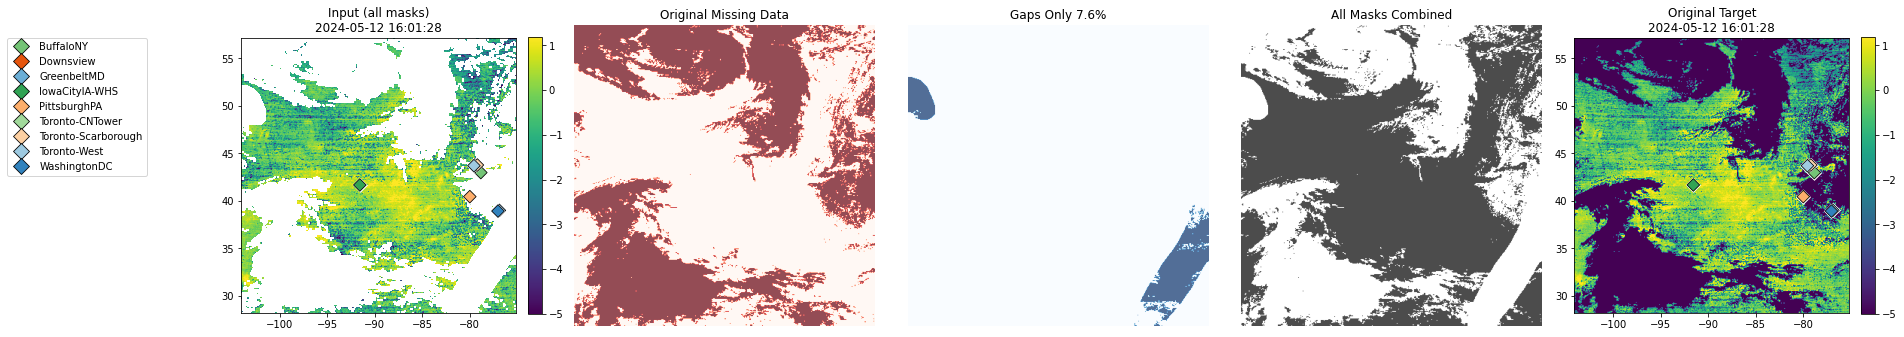

In [112]:
train_ds = TempoInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)

train_ds.sample_vis(train=True)

In [107]:
for i in range(50):
    print(np.unique(train_ds[i]['p_val_mask']))

[0.]
[0.000000e+00 4.792239e+14]
[0.0000000e+00 6.6424213e+14 4.2568105e+15 6.2672420e+15]
[0.0000000e+00 6.6899961e+14 3.7607064e+15 4.3046865e+15]
[0.0000000e+00 2.0595721e+15]
[0.0000000e+00 3.5516177e+15 9.1952072e+15 1.0962705e+16]
[0.0000000e+00 1.6773469e+15 3.5057289e+15 4.7379792e+15 5.6898991e+15
 7.2241602e+15 8.3394607e+15 1.1617914e+16]
[0.0000000e+00 8.7646237e+14 3.1077259e+15 3.2826086e+15 4.2688547e+15
 6.0889864e+15 6.4617568e+15 1.1460736e+16 1.2100890e+16]
[0.0000000e+00 9.3981528e+14 3.9458874e+15 8.3533114e+15]
[0.000000e+00 6.243153e+15]
[0.0000000e+00 1.0726035e+15 2.9336860e+15 6.4828344e+15 8.5622798e+15]
[0.0000000e+00 1.2138828e+15 4.8272276e+15 5.4223355e+15 6.6092997e+15]
[0.0000000e+00 1.9752019e+15 5.4868325e+15 7.0314515e+15 1.2677810e+16]
[0.0000000e+00 3.2430434e+15]
[0.0000000e+00 1.4283314e+15 4.7335833e+15 7.7246002e+15]
[0.0000000e+00 3.3155499e+15 3.9435386e+15 4.1805099e+15 5.7298863e+15
 8.9055417e+15 1.2046691e+16]
[0.0000000e+00 1.2823547e+15

KeyboardInterrupt: 

In [83]:
def train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    
    wait = 0

    history = []
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()

            pred_t, _ = model(img, mask_aug)
            loss = warmup_loss(pred_t, target, mask_aug)            
            
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug, known_mask)
            for key in batch_metrics:
                train_metrics[key] += batch_metrics[key]
            batch_count += 1
        visualize_batch(epoch, model,normalizer, train_loader, device="cuda",train=True, shp_path=shp_path,save=False)

        # Average metrics over batches
        train_loss /= len(train_loader)
        for key in train_metrics:
            train_metrics[key] /= batch_count

        # ---- Validation ----
        model.eval()
        val_loss = 0
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                pred, _ = model(img, mask)

                loss = warmup_loss(pred, target, mask)
                val_loss += loss.item()
                
                # Calculate metrics for fake mask regions
                batch_metrics = calculate_metrics(pred, target, mask)
                for key in batch_metrics:
                    val_metrics[key] += batch_metrics[key]
                batch_count += 1
                
        val_loss /= len(val_loader)
       
        visualize_batch(epoch, model, normalizer, val_loader, device="cuda", train=False, shp_path=shp_path,save = False)
        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        })
        
        with open('csv_history.csv', "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "train_loss", "val_loss", 
                "train_rmse", "train_mae", "train_r2",
                "pred_min_range", "pred_max_range"
            ])
            writer.writeheader()
            writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = PConvUNet2D(in_ch=1, out_ch=1, base_ch=32).cuda()
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)

  7%|▋         | 68/1043 [00:36<08:39,  1.88it/s]


KeyboardInterrupt: 